In [1]:
import sys  
sys.path.insert(0, "../src")

import numpy as np
import pandas as pd
import subprocess
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import time
from timeout import timeout as timeout_func
from tqdm import tqdm
import psycopg2
from pathlib import Path
from circuit_shapley import CircuitShapley
from collections import Counter

In [2]:
def get_connection(db="postgres"):
    user = "postgres"
    pwd = "postgres"
    host = "localhost"
    port = 5432

    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}?client_encoding=utf8'
    url = url.format(user, pwd, host, port, db)
    conn_args = 'dbname={} user={} password={} host={} port={}'
    conn_args = conn_args.format(db, user, pwd, host, port)
    return psycopg2.connect(conn_args)

def sudo_chmod(path):
    sudoPassword = 'admin'
    command = 'chmod -R 777 %s' % path
    os.system('echo %s|sudo -S %s' % (sudoPassword, command))

In [3]:
def execute_query(query_fname, query_result_fname, circuits_home):
    
    if query_result_fname.exists():
        with open(query_result_fname, 'r') as f:
            result = json.load(f)
    else:
        with open(query_fname, 'r') as f:
            query = f.read()

        circuit_path = circuits_home/db/query_fname.stem
        circuit_path.mkdir(parents=True, exist_ok=True)
        sudo_chmod(circuit_path)

        start = time.time()
        cur.execute(query.format(path=str(circuit_path/"circuit")))
        end = time.time()
        res = cur.fetchall()
        
        sudo_chmod(circuit_path)
        
        result = {
            "query_execution": end - start,
            "result": res
        }
        
        with open(query_result_fname, 'w') as f:
            json.dump(result, f, indent=4)
            
    return result


In [4]:
def knowledge_compilation(circuit_fname, timeout=150):
    proc = None
    try:
        proc = subprocess.Popen(["c2d", '-in', circuit_fname, '-smooth'])
        outs, errs = proc.communicate(timeout=timeout)
        if not Path(circuit_fname + '.nnf').exists():
            return "Exception - file not created"
        return "Success"
    except subprocess.TimeoutExpired:
        if proc is not None:
            proc.kill()
        return "Timeout"
    except Exception as e:
        if proc is not None:
            proc.kill()
        return str(type(e))

In [5]:
def calc_shapley_values(nnf_fname, gates_fname, timeout=150):
    
    def calc(nnf_fname, gates_fname):
        c_shapley = CircuitShapley(nnf_fname, gates_fname)
        return c_shapley.shapley_values()
    
    calc_timeout = timeout_func(timeout=timeout)(calc)
    try:
        shapley_values = calc_timeout(nnf_fname, gates_fname)
    except Exception as e:
        shapley_values = e
    
    return shapley_values

In [6]:
def save_json(fname, data):
    with open(fname, 'w') as f:
        json.dump(data, f, indent=4)

def process_circuit(inter_path, res_tuple, circuit_fname, provenance_hash, timeout=150):
    inter_path = inter_path/(Path(circuit_fname).stem)
    if inter_path.exists():
        with open(inter_path, 'r') as f:
            return json.load(f)
    
    cur_output = {
        "tuple": res_tuple,
        "circuit_fname": str(circuit_fname),
        "provenance_hash": provenance_hash
    }
    
    nnf_fname = str(circuit_fname) + '.nnf'
    gates_fname = str(circuit_fname) + '_gate'
    
    sudo_chmod(circuit_fname.parents[0])

    with open(circuit_fname, 'r') as f:
        cnf_header = f.readline().split()
        cur_output["cnf_n_variables"] = int(cnf_header[2])
        cur_output["cnf_n_clauses"] = int(cnf_header[3])

    if cur_output["cnf_n_variables"] > 1:
        # Save intermediate file before execution (will be overwritten in case the process completes)
        cur_output["comilation_status"] = "Crashed"
        save_json(inter_path, cur_output)
            
        start = time.time()
        compilation_status = knowledge_compilation(str(circuit_fname), timeout=timeout)
        end = time.time()

        cur_output["comilation_status"] = compilation_status

        if compilation_status == "Success":
            with open(nnf_fname, 'r') as f:
                nnf_header = f.readline().split()
                if len(nnf_header) == 0 or nnf_header[0] != "nnf":
                    cur_output["comilation_status"] = "Exception - file is corrupted"
                    save_json(inter_path, cur_output)
                    return cur_output
                cur_output["compilation_time"] = (end - start)
                cur_output["nnf_n_nodes"] = int(nnf_header[1])
                cur_output["nnf_n_edges"] = int(nnf_header[2])
                cur_output["nnf_n_variables"] = int(nnf_header[3])
            
            cur_output["shapley_status"] = "Crashed"
            save_json(inter_path, cur_output)

            start = time.time()
            shapley_values = calc_shapley_values(nnf_fname, gates_fname, timeout=timeout)
            end = time.time()

            if isinstance(shapley_values, Exception):
                cur_output["shapley_status"] = str(type(shapley_values))
            else: 
                cur_output["n_forget_gates"] = cur_output["nnf_n_variables"] - len(shapley_values)
                cur_output["shapley_status"] = "Success"
                cur_output["shapley_time"] = (end - start)
                cur_output["shapley_values"] = shapley_values
    else: 
        # Edge case where we have a single variable. In this case skip compilation and Shapley evaluation, since the variable value must be 1.0
        cur_output["comilation_status"] = "Success"
        cur_output["compilation_time"] = 0.0
        cur_output["n_forget_gates"] = 0
        cur_output["shapley_status"] = "Success"
        cur_output["shapley_time"] = 0.0
        cur_output["shapley_values"] = {1: 1.0}
        
    save_json(inter_path, cur_output)
    
    return cur_output

In [7]:
queries_home = Path('../queries')
circuits_home = Path('../circuits')
outputs_home = Path('../outputs')

timeout = 150

output = {}

for db_home in queries_home.iterdir():
    if db_home.is_dir():
        db = db_home.stem
        
        try:
            con = get_connection(db)
        except Exception:
            continue
        
        print('Start processing queries from ' + db)
        if db not in output:
            output[db] = {}
        
        try:
            cur = con.cursor()
            cur.execute("SET search_path TO public, provsql")
            
            for query_fname in db_home.iterdir():
                if query_fname.suffix != ".sql" or query_fname.stem in output[db]:
                    continue
                    
                print('\tWorking on ' + query_fname.stem)
                
                output_path = outputs_home/db/query_fname.stem
                output_inter_path = output_path/"intermediate"
                query_result_fname = output_path/"q_output.json"
                runtime_fname = output_path/"runtime.json"
                
                if runtime_fname.exists():
                    with open(runtime_fname, 'r') as f:
                        output[db][query_fname.stem] = json.load(f)
                        continue
                else:
                    output_path.mkdir(parents=True, exist_ok=True)
                    output_inter_path.mkdir(parents=True, exist_ok=True)
    
                # Execute (or load) the query
                query_rseult = execute_query(query_fname, query_result_fname, circuits_home.absolute())
                
                query_outputs = []
                output[db][query_fname.stem] = {
                    "query_execution": query_rseult["query_execution"],
                    "query_output_size": len(query_rseult["result"]),
                    "query_outputs": query_outputs
                }
                
                for x in tqdm(query_rseult["result"]):
                    cur_output = process_circuit(output_inter_path, x[0], Path(x[1]), x[2], timeout=timeout)
                    query_outputs.append(cur_output)
                
                
                with open(runtime_fname, 'w') as f:
                    json.dump(output[db][query_fname.stem], f, indent=4)
                    
        finally:
            con.close()

Start processing queries from tpch
	Working on 5
	Working on 8
	Working on 10
	Working on 1
	Working on 14
	Working on 11
	Working on 3
	Working on 16
	Working on 9
	Working on 12
	Working on 7
	Working on 19
	Working on 18
Start processing queries from imdb
	Working on 11a
	Working on 14c
	Working on 8d
	Working on 15d
	Working on 14a
	Working on 11c
	Working on 6b
	Working on 13a
	Working on 12b
	Working on 10b
	Working on 11b
	Working on 7c
	Working on 15c
	Working on 12a
	Working on 10a
	Working on 11d
	Working on 16a
	Working on 10c
	Working on 5a
	Working on 6a
	Working on 13b
	Working on 14b
	Working on 15a
	Working on 15b
	Working on 12c
	Working on 13c
	Working on 1a


## Success rate

In [8]:
queries = []
compilation_status = []
shapley_status = []
suc_tuples = []
suc_clauses = []
suc_nodes = []
fail_tuples = []
fail_clauses = []
fail_nodes = []

for db in output:
    for query in output[db]:
        for o in output[db][query]['query_outputs']:
            queries.append(query)
            compilation_status.append(o["comilation_status"])
            if o["comilation_status"] != "Success":
                shapley_status.append("Compilation Failure")
            else:
                shapley_status.append(o["shapley_status"])
                
            if "shapley_status" in o and o["shapley_status"] == "Success":
                suc_tuples.append(len(o["shapley_values"]))
                suc_clauses.append(o["cnf_n_clauses"])
                suc_nodes.append(o["nnf_n_nodes"] if o["cnf_n_variables"] > 1 else 1)
            else:
                forget_df = pd.read_csv(o['circuit_fname'] + '_gate', delimiter=' ', header=None)
                fail_tuples.append(o["cnf_n_variables"] - len(set(forget_df[0].unique())))
                fail_clauses.append(o["cnf_n_clauses"])
                if o["comilation_status"] == "Success":
                    fail_nodes.append(o["nnf_n_nodes"] if o["cnf_n_variables"] > 1 else 1)

In [9]:
Counter(compilation_status)

Counter({'Success': 95870,
         "<class 'OSError'>": 1,
         'Timeout': 20,
         'Exception - file not created': 4})

In [10]:
Counter(shapley_status)

Counter({'Success': 95616,
         "<class 'RecursionError'>": 2,
         'Compilation Failure': 25,
         "<class 'timeout.TimeoutException'>": 238,
         "<class 'OverflowError'>": 14})

## Aggregated running times

In [11]:
queries = []
cnf_n_variables = []
cnf_n_clauses = []
nnf_n_nodes = []
nnf_n_edges = []
n_tuples = []
compilation_time = []
shapley_time = []


for db in output:
    for query in output[db]:
        for o in output[db][query]['query_outputs']:
            if o["comilation_status"] != "Success" or o["shapley_status"] != "Success":
                continue
                
            queries.append(query)
            cnf_n_variables.append(o["cnf_n_variables"])
            cnf_n_clauses.append(o["cnf_n_clauses"])
            nnf_n_nodes.append(o["nnf_n_nodes"] if o["cnf_n_variables"] > 1 else 1)
            nnf_n_edges.append(o["nnf_n_edges"] if o["cnf_n_variables"] > 1 else 1)
            n_tuples.append(len(o["shapley_values"]))
            compilation_time.append(min(o["compilation_time"], timeout))
            shapley_time.append(min(o["shapley_time"], timeout))
            
df = pd.DataFrame({
    "Query": queries,
    "#variables": cnf_n_variables,
    "#CNF clauses": cnf_n_clauses,
    "#d-DNNF nodes": nnf_n_nodes,
    "#d-DNNF edges": nnf_n_edges,
    "#Tuples": n_tuples,
    "Compilation": compilation_time,
    "Shapley": shapley_time
})

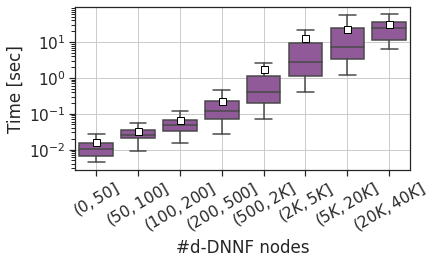

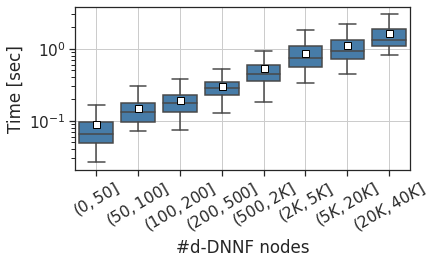

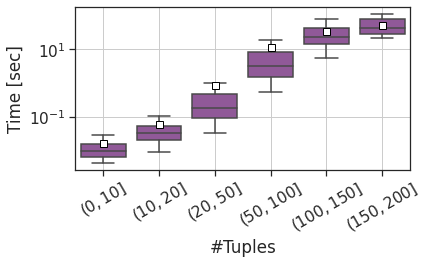

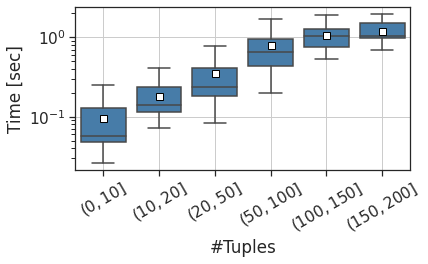

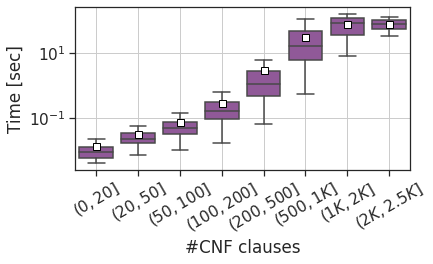

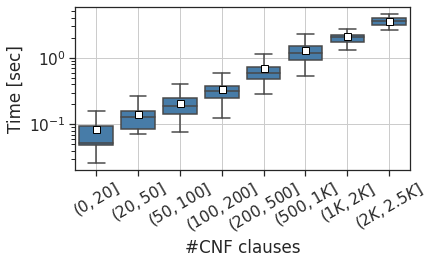

In [12]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set(font_scale = 1.4, context='notebook', style='ticks')

col2bins = {
    "#d-DNNF nodes": 
    {
        "values": [0, 50, 100, 200, 500, 2000, 5000, 20000, 40000],
        "labels": [r'$(0,50]$', r'$(50, 100]$', r'$(100,200]$', r'$(200,500]$', r'$(500, 2K]$', r'$(2K, 5K]$', r'$(5K, 20K]$', r'$(20K, 40K]$']
    },
    "#Tuples": 
    {
        "values": [0, 10, 20, 50, 100, 150, 200],
        "labels": [r'$(0,10]$', r'$(10, 20]$', r'$(20,50]$', r'$(50,100]$', r'$(100, 150]$', r'$(150, 200]$']
    },
    "#CNF clauses": 
    {
        "values": [0, 20, 50, 100, 200, 500, 1000, 2000, 2500],
        "labels": [r'$(0,20]$', r'$(20, 50]$', r'$(50, 100]$', r'$(100, 200]$', r'$(200,500]$', r'$(500,1K]$', r'$(1K, 2K]$', r'$(2K, 2.5K]$']
    }    
}

for col in col2bins:

    a = df[["Query", col, "Compilation", "Shapley"]]
    a = pd.melt(a, id_vars=["Query", col], var_name="Phase", value_name="Time [sec]")
    a.loc[:, col] = pd.cut(a[col], bins=col2bins[col]["values"], 
                           labels=col2bins[col]["labels"], 
                           duplicates="drop")

    for phase, color in [("Shapley", "#984ea3"), ("Compilation", "#377eb8")]:
        ax = sns.boxplot(x=col, y="Time [sec]", data=a[a.Phase == phase], 
                     showfliers=False, color=color,
                     showmeans=True, meanprops={"marker":"s", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":7})
        ax.set_yscale('log')
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        plt.grid(True)
        plt.show()

## Contribution analysis

In [13]:
def calc_cover(vs, r):
    vs = np.array(list(vs.values()))
    vs.sort()
    vs = vs[::-1]
    s = 0
    c = 0
    for v in vs:
        s += v
        c += 1
        if s >= r:
            break
    return c


n_tuples = []
cover5 = []
cover6 = []
cover7 = []
cover8 = []
cover9 = []



for db in output:
    for query in output[db]:
        for o in output[db][query]['query_outputs']:
            if o["comilation_status"] != "Success" or o["shapley_status"] != "Success":
                continue
            
            vs = o["shapley_values"]
            n_tuples.append(len(vs))
            
            cover6.append(calc_cover(vs, .6))
            cover7.append(calc_cover(vs, .7))
            cover8.append(calc_cover(vs, .8))
            cover9.append(calc_cover(vs, .9))

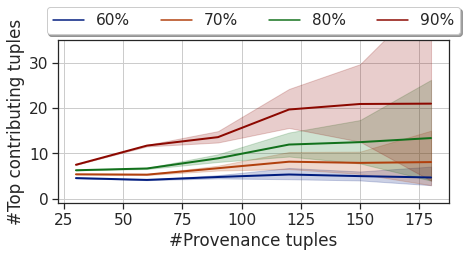

In [14]:
df = pd.DataFrame({
    "#Provenance tuples": n_tuples,
    "60%": cover6,
    "70%": cover7,
    "80%": cover8,
    "90%": cover9
})
step = 30
df.loc[:, "#Provenance tuples"] = df["#Provenance tuples"].apply(lambda x: step * int(1 + x/step))

a = df.melt(id_vars=["#Provenance tuples"], var_name="Ratio", value_name="#Top contributing tuples")

fig = plt.figure(figsize=(7,3))

ax = sns.lineplot(data=a, x='#Provenance tuples', y="#Top contributing tuples", hue="Ratio", linewidth=2,
                  palette=sns.color_palette("dark", 4), ci=95)

ax.set_ylim([-1, 35])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, fancybox=True, shadow=True)
plt.grid(True)
plt.show()